# NOAA Global Historical Climatology Network Daily (GHCN-D)
Find out details about AWS OpenData dataset [here](https://registry.opendata.aws/noaa-ghcn/).

Detailed documentation [here](https://docs.opendata.aws/noaa-ghcn-pds/readme.html).

The yearly files are formatted so that every observation is represented by a single row with the following fields:

- ID = 11 character station identification code. Please see ghcnd-stations section below for an explantation
- YEAR/MONTH/DAY = 8 character date in YYYYMMDD format (e.g. 19860529 = May 29, 1986)
- ELEMENT = 4 character indicator of element type
- DATA VALUE = 5 character data value for ELEMENT
- M-FLAG = 1 character Measurement Flag
- Q-FLAG = 1 character Quality Flag
- S-FLAG = 1 character Source Flag
- OBS-TIME = 4-character time of observation in hour-minute format (i.e. 0700 =7:00 am)

ELEMENT Summary
The five core elements are:

- PRCP = Precipitation (tenths of mm)
- SNOW = Snowfall (mm)
- SNWD = Snow depth (mm)
- TMAX = Maximum temperature (tenths of degrees C)
- TMIN = Minimum temperature (tenths of degrees C)

More

- AWND = Average daily wind speed (tenths of meters per second)
- WSF2 = Fastest 2-minute wind speed (tenths of meters per second)
- WSF5 = Fastest 5-second wind speed (tenths of meters per second)
- TAVG = Average temperature (tenths of degrees C) [Note that TAVG from source ’S’ corresponds to an average for the period ending at 2400 UTC rather than local midnight]

## Download data

In [1]:
!aws s3 ls s3://noaa-ghcn-pds/ --no-sign-request

                           PRE csv.gz/
                           PRE csv/
2021-01-13 02:31:06       1164 by-year-status.txt
2020-05-19 12:42:15      32554 ghcn-daily-by_year-format.rtf
2021-03-30 20:43:26       3659 ghcnd-countries.txt
2021-05-27 11:56:43   32403734 ghcnd-inventory.txt
2021-03-30 20:43:35       1086 ghcnd-states.txt
2021-05-27 11:56:43   10190312 ghcnd-stations.txt
2021-06-03 13:58:26        270 ghcnd-version.txt
2021-05-12 18:29:33      32357 index.html
2021-03-30 20:47:52    4100835 mingle-list.txt
2021-03-30 20:43:35       1106 readme-by_year.txt
2021-03-30 20:43:26      26612 readme.txt
2021-04-27 04:27:28        169 status-by_year.txt
2021-04-24 16:49:35      34783 status.txt


In [2]:
# !aws s3 ls s3://noaa-ghcn-pds/csv.gz/ --no-sign-request
# !aws s3 cp s3://noaa-ghcn-pds/csv.gz/2020.csv.gz --no-sign-request .
# !aws s3 cp s3://noaa-ghcn-pds/ghcnd-stations.txt --no-sign-request .
# !aws s3 ls s3://noaa-ghcn-pds/csv/ --no-sign-request

# !aws s3 cp s3://noaa-ghcn-pds/csv/2020.csv --no-sign-request .

## Explore NOAA data, and establish a dataframe for all of 2020 (34 million records)

In [3]:
import pandas as pd

In [4]:
!ls

2020.csv
2020.csv.gz
bos_weather_daily.csv
bos_weather_daily_v2.csv
by-year-status.txt
ghcn-daily-by_year-format.rtf
ghcnd-countries.txt
ghcnd-inventory.txt
ghcnd-states.txt
ghcnd-stations.txt
ghcnd-version.txt
index.html
master-location-identifier-database-202103_standard.csv
mingle-list.txt
mlid.csv
noaa-climatology-network-daily.ipynb
__pycache__
readme-by_year.txt
readme.txt
status.txt
tmp.csv
tmp.sql
Utils.py


In [40]:
full_2020_df = pd.read_csv('2020.csv', header=None)

In [41]:
full_2020_df.head()

,0,1,2,3,4,5,6,7
0,AE000041196,20200101,TMIN,168,NaN,NaN,S,NaN
1,AE000041196,20200101,PRCP,0,D,NaN,S,NaN
2,AE000041196,20200101,TAVG,211,H,NaN,S,NaN
3,AEM00041194,20200101,PRCP,0,NaN,NaN,S,NaN
4,AEM00041194,20200101,TAVG,217,H,NaN,S,NaN


In [42]:
full_2020_df.shape

(34514698, 8)

## Map airport codes to weather station ID's
The daily NOAA weather data is keyed by its own Station ID's. While this is helpful, there are other applications that won't have a Station ID to drive a lookup. For our example, we want to be able to find the weather at a given airport. 

[Here](http://www.weathergraphics.com/identifiers/) is a Master Location Identifier Database with over 45,000 government weather station identifiers worldwide. They publish a free standard version as a CSV, [here](http://www.weathergraphics.com/identifiers/master-location-identifier-database-202103_standard.csv), along with corresponding [documentation](http://www.weathergraphics.com/identifiers/master-location-identifier-database-202103.pdf).

In this section of the notebook, we prepare a dataframe to map between station ID's and airport ID's. About 3,000 of the MLID records have a complete mapping between NOAA station ID's, ICAO's, and IATA's.

[Here](https://en.wikipedia.org/wiki/List_of_airports_by_IATA_and_ICAO_code) is the list of IATA and ICAO codes.

Here are the NOAA station columns available according to the [documentation](https://www.ncdc.noaa.gov/ghcnd-data-access):

- Station ID
- latitude, longitude, elevation
- 2-digit State code (if applicable)
- and Station name.

#### Download the free MLID mapping file

In [9]:
!head -6 master-location-identifier-database-202103_standard.csv

#### Strip off the top 4 lines, leaving the first line as the CSV header

In [10]:
!tail -n +5 master-location-identifier-database-202103_standard.csv > mlid.csv

In [11]:
!wc -l mlid.csv

41682 mlid.csv


In [12]:
!head -3 mlid.csv

#### Prepare a dataframe of all mapping rows that have a GHCN station ID, an ICAO (4-char) airport code, and a IATA (3-char) airport code

In [17]:
mlid_df = pd.read_csv('mlid.csv', encoding = "ISO-8859-1")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
mlid_df[['station_name','national_id','icao']].head()

,station_name,national_id,icao
0,John A. Osborne AP,NaN,NaN
1,"Juancho E. Yrausquin AP, Saba",NaN,NaN
2,Kyzylabad,NaN,OAMS
3,Camp Spann,NaN,KQSP
4,Camp Marmal,NaN,KQML


In [19]:
mlid_df.shape

(41681, 20)

In [20]:
mlid_df = mlid_df[['country3','region','place_name','station_name','icao','national_id','ghcn']]
mlid_df.columns = ['country3','region','place_name','station_name','icao','iata','ghcn']
mlid_df.head()

,country3,region,place_name,station_name,icao,iata,ghcn
0,ABW,-,Old Norwood,John A. Osborne AP,NaN,NaN,NaN
1,ABW,SA,Upper Hell's Gate,"Juancho E. Yrausquin AP, Saba",NaN,NaN,NaN
2,AFG,BAL,Kyzylabad|Mazar-I-Sharif|Qizil?b?d,Kyzylabad,OAMS,NaN,NaN
3,AFG,BAL,Pushti-Bag|Mazari Sharif|Dehd?d?,Camp Spann,KQSP,NaN,NaN
4,AFG,BAL,Qala-i-Gul Mohd|Mazari Sharif|Qizil?b?d,Camp Marmal,KQML,NaN,NaN


In [21]:
mlid_df = mlid_df.dropna(subset=['ghcn', 'icao', 'iata'])

In [22]:
mlid_df.shape

(3042, 7)

## Explore ground stations metadata

In [23]:
!head ghcnd-stations.txt

ACW00011604  17.1167  -61.7833   10.1    ST JOHNS COOLIDGE FLD                       
ACW00011647  17.1333  -61.7833   19.2    ST JOHNS                                    
AE000041196  25.3330   55.5170   34.0    SHARJAH INTER. AIRP            GSN     41196
AEM00041194  25.2550   55.3640   10.4    DUBAI INTL                             41194
AEM00041217  24.4330   54.6510   26.8    ABU DHABI INTL                         41217
AEM00041218  24.2620   55.6090  264.9    AL AIN INTL                            41218
AF000040930  35.3170   69.0170 3366.0    NORTH-SALANG                   GSN     40930
AFM00040938  34.2100   62.2280  977.2    HERAT                                  40938
AFM00040948  34.5660   69.2120 1791.3    KABUL INTL                             40948
AFM00040990  31.5000   65.8500 1010.0    KANDAHAR AIRPORT                       40990


Find all international airports

In [24]:
!grep "INTL AP" ghcnd-stations.txt

BDM00078016  32.3667  -64.6833    6.1    L F WADE INTL AP KINDLEY FLD   GSN     78016
CQC00914855  15.1167  145.7167   65.5 MP SAIPAN INTL AP                         91232
GQW00041415  13.4836  144.7961   77.4 GU GUAM INTL AP                   GSN     91212
TDM00078970  10.5830  -61.3500   12.2    PIARCO INTL AP                         78970
USC00052212  39.8308 -104.6867 1633.7 CO DENVER INTL AP 2SW                          
USW00003017  39.8328 -104.6575 1650.2 CO DENVER INTL AP                         72565
USW00003102  34.0561 -117.6003  289.3 CA ONTARIO INTL AP                             
USW00003196  31.4208 -110.8458 1198.5 AZ NOGALES INTL AP                             
USW00003822  32.1300  -81.2100   14.0 GA SAVANNAH INTL AP                   HCN 72207
USW00003856  34.6439  -86.7861  190.2 AL HUNTSVILLE INTL AP                     72323
USW00003940  32.3206  -90.0778  100.6 MS JACKSON INTL AP                        72235
USW00003947  39.2972  -94.7306  306.3 MO KANSAS CITY I

Weather history for Boston, charts by month [here](https://www.wunderground.com/history/monthly/us/ma/boston/KBOS/date/2020-2)

In [25]:
!grep "BOSTON LOGAN" ghcnd-stations.txt

USW00014739  42.3606  -71.0106    3.7 MA BOSTON LOGAN INTL AP                   72509


In [26]:
target_station = 'USW00014739' # Logan airport

## Add a couple of date features

In [27]:
def to_YYYY_MM_DD(yyyymmdd_num):
    yyyymmdd = str(yyyymmdd_num)
    y = int(yyyymmdd[0:4])
    m = int(yyyymmdd[4:6])
    d = int(yyyymmdd[6:8])
    return f'{y}-{m:02d}-{d:02d}'

In [43]:
full_2020_df['weather_date'] = full_2020_df[1].apply(to_YYYY_MM_DD)

In [44]:
full_2020_df['month'] = full_2020_df['weather_date'].str[5:7].astype(int)

In [45]:
full_2020_df.tail()

,0,1,2,3,4,5,6,7,weather_date,month
34514693,WFM00091754,20201231,TMAX,310,NaN,NaN,S,NaN,2020-12-31,12
34514694,WFM00091754,20201231,TMIN,260,NaN,NaN,S,NaN,2020-12-31,12
34514695,WFM00091754,20201231,TAVG,282,H,NaN,S,NaN,2020-12-31,12
34514696,WIM00060096,20201231,TMIN,156,NaN,NaN,S,NaN,2020-12-31,12
34514697,WIM00060096,20201231,TAVG,182,H,NaN,S,NaN,2020-12-31,12


In [46]:
full_2020_df.columns = ['station_id','date_as_num','element','value','4','5','6','7','weather_date','month']
full_2020_df.head()

,station_id,date_as_num,element,value,4,5,6,7,weather_date,month
0,AE000041196,20200101,TMIN,168,NaN,NaN,S,NaN,2020-01-01,1
1,AE000041196,20200101,PRCP,0,D,NaN,S,NaN,2020-01-01,1
2,AE000041196,20200101,TAVG,211,H,NaN,S,NaN,2020-01-01,1
3,AEM00041194,20200101,PRCP,0,NaN,NaN,S,NaN,2020-01-01,1
4,AEM00041194,20200101,TAVG,217,H,NaN,S,NaN,2020-01-01,1


In [47]:
full_2020_df.shape

(34514698, 10)

## Move from long table (34M) to wide table (12M)
Instead of a separate row for each and every observation, move weather observations to columns with each row representing a single station on a single day.

In [48]:
full_2020_df.drop(['4','5','6','7'], axis=1, inplace=True)
full_2020_df.head()

,station_id,date_as_num,element,value,weather_date,month
0,AE000041196,20200101,TMIN,168,2020-01-01,1
1,AE000041196,20200101,PRCP,0,2020-01-01,1
2,AE000041196,20200101,TAVG,211,2020-01-01,1
3,AEM00041194,20200101,PRCP,0,2020-01-01,1
4,AEM00041194,20200101,TAVG,217,2020-01-01,1


In [49]:
focused_df = full_2020_df[full_2020_df.element.isin(['PRCP','SNOW','TAVG','TMIN','AWND','WSF2','WSF5'])]

In [50]:
focused_df.head()

,station_id,date_as_num,element,value,weather_date,month
0,AE000041196,20200101,TMIN,168,2020-01-01,1
1,AE000041196,20200101,PRCP,0,2020-01-01,1
2,AE000041196,20200101,TAVG,211,2020-01-01,1
3,AEM00041194,20200101,PRCP,0,2020-01-01,1
4,AEM00041194,20200101,TAVG,217,2020-01-01,1


In [51]:
wide_df = focused_df.pivot(index=['station_id','weather_date'], columns='element', values='value')

In [52]:
wide_df.shape

(11882097, 7)

In [53]:
wide_df.head()

element                   AWND  PRCP  SNOW   TAVG   TMIN  WSF2  WSF5
station_id  weather_date                                            
AE000041196 2020-01-01     NaN   0.0   NaN  211.0  168.0   NaN   NaN
            2020-01-02     NaN   0.0   NaN  214.0    NaN   NaN   NaN
            2020-01-03     NaN   0.0   NaN  212.0  154.0   NaN   NaN
            2020-01-04     NaN   0.0   NaN  219.0  149.0   NaN   NaN
            2020-01-05     NaN   0.0   NaN  237.0  165.0   NaN   NaN

Look for some snowy days.

In [54]:
wide_df[wide_df.SNOW > 0].head(20)

element                   AWND   PRCP   SNOW  TAVG  TMIN  WSF2  WSF5
station_id  weather_date                                            
CA001011500 2020-04-03     NaN   20.0    2.0  45.0  15.0   NaN   NaN
            2020-12-21     NaN  518.0  132.0  33.0   5.0   NaN   NaN
CA001012055 2020-12-20     NaN  752.0   58.0   NaN   NaN   NaN   NaN
            2020-12-21     NaN  114.0   78.0   3.0 -15.0   NaN   NaN
CA001015105 2020-12-20     NaN  228.0   10.0   NaN   NaN   NaN   NaN
            2020-12-21     NaN  354.0   60.0   NaN   NaN   NaN   NaN
CA001015628 2020-12-20     NaN  166.0   32.0   NaN   NaN   NaN   NaN
            2020-12-21     NaN  202.0  102.0   NaN   NaN   NaN   NaN
CA001015638 2020-12-21     NaN  116.0   80.0  35.0  15.0   NaN   NaN
CA001016335 2020-12-21     NaN  390.0   10.0  20.0   5.0   NaN   NaN
CA001016940 2020-12-21     NaN  130.0  130.0  20.0   5.0   NaN   NaN
CA001016995 2020-12-20     NaN  285.0   80.0  85.0  65.0   NaN   NaN
            2020-12-21     NaN  108.0   12.0  25.0   5.0   NaN   NaN
CA001016RM0 2020-12-20     NaN  278.0   50.0   NaN   NaN   NaN   NaN
            2020-12-21     NaN  776.0  650.0   NaN   NaN   NaN   NaN
CA001017230 2020-12-20     NaN  160.0   30.0  68.0  45.0   NaN   NaN
            2020-12-21     NaN  250.0  250.0  10.0   5.0   NaN   NaN
CA001021261 2020-04-04     NaN    6.0    2.0  33.0   0.0   NaN   NaN
            2020-11-16     NaN  359.0   34.0  40.0 -15.0   NaN   NaN
CA001021330 2020-11-16     NaN  371.0   20.0  55.0  15.0   NaN   NaN

In [56]:
wide_df.reset_index(inplace=True)
wide_df.head()

element,station_id,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5
0,AE000041196,2020-01-01,NaN,0.0,NaN,211.0,168.0,NaN,NaN
1,AE000041196,2020-01-02,NaN,0.0,NaN,214.0,NaN,NaN,NaN
2,AE000041196,2020-01-03,NaN,0.0,NaN,212.0,154.0,NaN,NaN
3,AE000041196,2020-01-04,NaN,0.0,NaN,219.0,149.0,NaN,NaN
4,AE000041196,2020-01-05,NaN,0.0,NaN,237.0,165.0,NaN,NaN


In [57]:
wide_df.shape

(11882097, 9)

## Add features in inches, farenheit, mph
The default units of measurement don't match the typical usage needed by our models, so convert them to more usable units.

In [58]:
def tenths_meters_per_sec_to_mph(tm):
    meters_per_sec = tm / 10
    meters_per_hour = meters_per_sec * 60 * 60
    miles_per_hour = (meters_per_hour / 1000) / 1.6
    return round(miles_per_hour, 1)

In [59]:
def tenths_mm_to_in(tmm):
    mm = tmm / 10
    inches = mm / 25.4
    return round(inches, 1)

def mm_to_in(mm):
    inches = mm / 25.4
    return round(inches, 1)

In [60]:
def c_tenths_to_f(c_temp):
    return ((c_temp/10) * 1.8) + 32.0

In [61]:
c_tenths_to_f(41)

39.38

In [62]:
wide_df['WSF2_MPH'] = wide_df['WSF2'].apply(tenths_meters_per_sec_to_mph)
wide_df['WSF5_MPH'] = wide_df['WSF5'].apply(tenths_meters_per_sec_to_mph)
wide_df['AWND_MPH'] = wide_df['AWND'].apply(tenths_meters_per_sec_to_mph)

In [63]:
wide_df['PRCP_IN'] = wide_df['PRCP'].apply(tenths_mm_to_in)
wide_df['SNOW_IN'] = wide_df['SNOW'].apply(mm_to_in)

In [64]:
wide_df['TAVG_F'] = wide_df['TAVG'].apply(c_tenths_to_f)
wide_df['TMIN_F'] = wide_df['TMIN'].apply(c_tenths_to_f)

In [65]:
wide_df.head()

element,station_id,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F
0,AE000041196,2020-01-01,NaN,0.0,NaN,211.0,168.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,69.98,62.24
1,AE000041196,2020-01-02,NaN,0.0,NaN,214.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,70.52,NaN
2,AE000041196,2020-01-03,NaN,0.0,NaN,212.0,154.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,70.16,59.72
3,AE000041196,2020-01-04,NaN,0.0,NaN,219.0,149.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,71.42,58.82
4,AE000041196,2020-01-05,NaN,0.0,NaN,237.0,165.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,74.66,61.70


## Ingest this dataset in Feature Store

In [66]:
airport_weather_df = wide_df.copy()

In [67]:
airport_weather_df.columns

Index(['station_id', 'weather_date', 'AWND', 'PRCP', 'SNOW', 'TAVG', 'TMIN',
       'WSF2', 'WSF5', 'WSF2_MPH', 'WSF5_MPH', 'AWND_MPH', 'PRCP_IN',
       'SNOW_IN', 'TAVG_F', 'TMIN_F'],
      dtype='object', name='element')

In [68]:
airport_weather_df.shape

(11882097, 16)

#### Browse the weather at a couple of locations

In [69]:
airport_weather_df[airport_weather_df.station_id == 'USW00014739'].head()

element,station_id,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F
11570604,USW00014739,2020-01-01,69.0,0.0,0.0,41.0,22.0,130.0,188.0,29.2,42.3,15.5,0.0,0.0,39.38,35.96
11570605,USW00014739,2020-01-02,56.0,0.0,0.0,42.0,11.0,94.0,125.0,21.2,28.1,12.6,0.0,0.0,39.56,33.98
11570606,USW00014739,2020-01-03,32.0,0.0,0.0,82.0,67.0,76.0,94.0,17.1,21.2,7.2,0.0,0.0,46.76,44.06
11570607,USW00014739,2020-01-04,24.0,33.0,0.0,81.0,44.0,63.0,81.0,14.2,18.2,5.4,0.1,0.0,46.58,39.92
11570608,USW00014739,2020-01-05,74.0,28.0,0.0,39.0,0.0,139.0,183.0,31.3,41.2,16.6,0.1,0.0,39.02,32.00


In [70]:
airport_weather_df[airport_weather_df.station_id == 'USW00013897'].head()

element,station_id,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F
11548292,USW00013897,2020-01-01,27.0,0.0,0.0,57.0,6.0,76.0,98.0,17.1,22.1,6.1,0.0,0.0,42.26,33.08
11548293,USW00013897,2020-01-02,43.0,312.0,0.0,94.0,78.0,94.0,125.0,21.2,28.1,9.7,1.2,0.0,48.92,46.04
11548294,USW00013897,2020-01-03,18.0,99.0,0.0,126.0,111.0,45.0,72.0,10.1,16.2,4.0,0.4,0.0,54.68,51.98
11548295,USW00013897,2020-01-04,44.0,8.0,0.0,86.0,17.0,89.0,130.0,20.0,29.2,9.9,0.0,0.0,47.48,35.06
11548296,USW00013897,2020-01-05,29.0,0.0,0.0,45.0,-16.0,81.0,103.0,18.2,23.2,6.5,0.0,0.0,40.10,29.12


#### Handle missing data as zeros for temperature, precipitation, wind speed

In [71]:
airport_weather_df.fillna(0, inplace=True)

In [72]:
airport_weather_df.head()

element,station_id,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F
0,AE000041196,2020-01-01,0.0,0.0,0.0,211.0,168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.98,62.24
1,AE000041196,2020-01-02,0.0,0.0,0.0,214.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.52,0.00
2,AE000041196,2020-01-03,0.0,0.0,0.0,212.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.16,59.72
3,AE000041196,2020-01-04,0.0,0.0,0.0,219.0,149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.42,58.82
4,AE000041196,2020-01-05,0.0,0.0,0.0,237.0,165.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.66,61.70


#### Join in MLID database to map station_id to iata (3-char airport code)
Note that since only 3,000 stations are covered, this cuts our weather dataset from 12M rows down to 464K rows of weather data covering airports that we can look up by 3-character airport codes.

In [76]:
mlid_df.head()

,country3,region,place_name,station_name,icao,iata,ghcn
846,ATA,-,South Pole (Antarctica),South Pole Amundsen-Scott Station,NZSP,NPX,AYW00090001
1295,AUS,NT,Alice Springs|Alice Spring|Amoonguna,AP MET,YBAS,ASP,ASN00015590
5726,CAN,AB,Abee,AGDM,CXAF,XAF,CA003010010
5732,CAN,AB,Andrew,AGDM,CXAG,XAG,CA003010237
5740,CAN,AB,Atmore|Grassland,AGDM,CXAJ,XAJ,CA003060406


In [75]:
mlid_df.shape

(3042, 7)

In [77]:
airport_weather_df.shape

(11882097, 16)

In [78]:
airport_weather_df = pd.merge(airport_weather_df, mlid_df[['iata','icao','ghcn']], 
                              left_on='station_id', right_on='ghcn', how='inner')

In [79]:
airport_weather_df.head()

,station_id,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F,iata,icao,ghcn
0,ASN00015590,2020-01-01,0.0,0.0,0.0,332.0,227.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.76,72.86,ASP,YBAS,ASN00015590
1,ASN00015590,2020-01-02,0.0,0.0,0.0,356.0,237.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.08,74.66,ASP,YBAS,ASN00015590
2,ASN00015590,2020-01-03,0.0,0.0,0.0,354.0,288.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.72,83.84,ASP,YBAS,ASN00015590
3,ASN00015590,2020-01-04,0.0,0.0,0.0,279.0,273.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.22,81.14,ASP,YBAS,ASN00015590
4,ASN00015590,2020-01-05,0.0,84.0,0.0,233.0,193.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,73.94,66.74,ASP,YBAS,ASN00015590


In [97]:
airport_weather_df.shape

(464821, 20)

#### Add an event time to make this dataset ready to ingest to a feature group
We will use the existing weather date (in 'YYYY-MM-DD' format) as a base, and extend it to ISO 8601 format with the time of day. For each of 3,000 airports, we have daily weather observations for all days in 2020. Once ingested, the latest feature values will be for December 31, 2020. The online store will hold these values to help with inference. The offline store will hold the history of each feature, with a separate record for each day. All times are flagged as start of day.

In [81]:
airport_weather_df['event_time'] = airport_weather_df['weather_date']+'T00:00:00Z'

In [84]:
airport_weather_df[['iata','event_time','AWND','TMIN_F']].head()

,iata,event_time,AWND,TMIN_F
0,ASP,2020-01-01T00:00:00Z,0.0,72.86
1,ASP,2020-01-02T00:00:00Z,0.0,74.66
2,ASP,2020-01-03T00:00:00Z,0.0,83.84
3,ASP,2020-01-04T00:00:00Z,0.0,81.14
4,ASP,2020-01-05T00:00:00Z,0.0,66.74


In [85]:
airport_weather_df[airport_weather_df.station_id == 'USW00013897'].head()

,station_id,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F,iata,icao,ghcn,event_time
214114,USW00013897,2020-01-01,27.0,0.0,0.0,57.0,6.0,76.0,98.0,17.1,22.1,6.1,0.0,0.0,42.26,33.08,BNA,KBNA,USW00013897,2020-01-01T00:00:00Z
214115,USW00013897,2020-01-02,43.0,312.0,0.0,94.0,78.0,94.0,125.0,21.2,28.1,9.7,1.2,0.0,48.92,46.04,BNA,KBNA,USW00013897,2020-01-02T00:00:00Z
214116,USW00013897,2020-01-03,18.0,99.0,0.0,126.0,111.0,45.0,72.0,10.1,16.2,4.0,0.4,0.0,54.68,51.98,BNA,KBNA,USW00013897,2020-01-03T00:00:00Z
214117,USW00013897,2020-01-04,44.0,8.0,0.0,86.0,17.0,89.0,130.0,20.0,29.2,9.9,0.0,0.0,47.48,35.06,BNA,KBNA,USW00013897,2020-01-04T00:00:00Z
214118,USW00013897,2020-01-05,29.0,0.0,0.0,45.0,-16.0,81.0,103.0,18.2,23.2,6.5,0.0,0.0,40.10,29.12,BNA,KBNA,USW00013897,2020-01-05T00:00:00Z


#### Create and load the feature group

In [86]:
import Utils
Utils.create_fg_from_df('airport-weather-fg-v6', airport_weather_df, id_name='iata', event_time_name='event_time', 
                  tags={'Category':'Weather'}, online=True)

Waiting for Feature Group Creation
Waiting for Feature Group Creation
FeatureGroup airport-weather-fg-v6 successfully created.


In [89]:
Utils.ingest_from_df('airport-weather-fg-v6', airport_weather_df, max_processes=24, max_workers=4, wait=True)

#### Confirm the features have been loaded

In [91]:
Utils.get_latest_feature_values('airport-weather-fg-v6', ['BOS','BNA','LAX'])

[{'station_id': 'USW00014739',
  'weather_date': '2020-12-31',
  'AWND': 64.0,
  'PRCP': 25.0,
  'SNOW': 0.0,
  'TAVG': 54.0,
  'TMIN': 6.0,
  'WSF2': 125.0,
  'WSF5': 152.0,
  'WSF2_MPH': 28.1,
  'WSF5_MPH': 34.2,
  'AWND_MPH': 14.4,
  'PRCP_IN': 0.1,
  'SNOW_IN': 0.0,
  'TAVG_F': 41.72,
  'TMIN_F': 33.08,
  'iata': 'BOS',
  'icao': 'KBOS',
  'ghcn': 'USW00014739',
  'event_time': '2020-12-31T00:00:00Z'},
 {'station_id': 'USW00013897',
  'weather_date': '2020-12-31',
  'AWND': 38.0,
  'PRCP': 0.0,
  'SNOW': 0.0,
  'TAVG': 71.0,
  'TMIN': 50.0,
  'WSF2': 67.0,
  'WSF5': 81.0,
  'WSF2_MPH': 15.1,
  'WSF5_MPH': 18.2,
  'AWND_MPH': 8.5,
  'PRCP_IN': 0.0,
  'SNOW_IN': 0.0,
  'TAVG_F': 44.78,
  'TMIN_F': 41.0,
  'iata': 'BNA',
  'icao': 'KBNA',
  'ghcn': 'USW00013897',
  'event_time': '2020-12-31T00:00:00Z'},
 {'station_id': 'USW00023174',
  'weather_date': '2020-12-31',
  'AWND': 38.0,
  'PRCP': 0.0,
  'SNOW': 0.0,
  'TAVG': 124.0,
  'TMIN': 61.0,
  'WSF2': 103.0,
  'WSF5': 125.0,
  'WSF2_

#### Get the record count from the offline store, including all history
Note that there is a delay between the ingestion and the full replication of all records to the offline store, typically on the order of 5 minutes.

In [99]:
Utils.get_historical_record_count('airport-weather-fg-v6')

464821

#### Get offline history for a specific record id (Boston Logan airport)

In [94]:
Utils.get_historical_offline_feature_values('airport-weather-fg-v6', record_ids=['BOS'])

Running query:
 SELECT * FROM "airport-weather-fg-v6-1622809160"  WHERE  iata IN ('BOS')


,station_id,weather_date,awnd,prcp,snow,tavg,tmin,wsf2,wsf5,wsf2_mph,...,snow_in,tavg_f,tmin_f,iata,icao,ghcn,event_time,write_time,api_invocation_time,is_deleted
0,USW00014739,2020-01-01,69.0,0.0,0.0,41.0,22.0,130.0,188.0,29.2,...,0.0,39.38,35.96,BOS,KBOS,USW00014739,2020-01-01T00:00:00Z,2021-06-04 12:22:55.393,2021-06-04 12:22:30.000,False
1,USW00014739,2020-01-06,30.0,0.0,0.0,4.0,-27.0,94.0,134.0,21.2,...,0.0,32.72,27.14,BOS,KBOS,USW00014739,2020-01-06T00:00:00Z,2021-06-04 12:22:54.962,2021-06-04 12:22:30.000,False
2,USW00014739,2020-01-05,74.0,28.0,0.0,39.0,0.0,139.0,183.0,31.3,...,0.0,39.02,32.00,BOS,KBOS,USW00014739,2020-01-05T00:00:00Z,2021-06-04 12:22:55.334,2021-06-04 12:22:30.000,False
3,USW00014739,2020-01-02,56.0,0.0,0.0,42.0,11.0,94.0,125.0,21.2,...,0.0,39.56,33.98,BOS,KBOS,USW00014739,2020-01-02T00:00:00Z,2021-06-04 12:22:54.920,2021-06-04 12:22:30.000,False
4,USW00014739,2020-01-03,32.0,0.0,0.0,82.0,67.0,76.0,94.0,17.1,...,0.0,46.76,44.06,BOS,KBOS,USW00014739,2020-01-03T00:00:00Z,2021-06-04 12:22:54.420,2021-06-04 12:22:30.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,USW00014739,2020-12-31,64.0,25.0,0.0,54.0,6.0,125.0,152.0,28.1,...,0.0,41.72,33.08,BOS,KBOS,USW00014739,2020-12-31T00:00:00Z,2021-06-04 12:23:02.991,2021-06-04 12:22:37.000,False
362,USW00014739,2020-12-24,58.0,0.0,0.0,39.0,-10.0,125.0,148.0,28.1,...,0.0,39.02,30.20,BOS,KBOS,USW00014739,2020-12-24T00:00:00Z,2021-06-04 12:23:03.321,2021-06-04 12:22:37.000,False
363,USW00014739,2020-12-28,42.0,0.0,0.0,27.0,-21.0,103.0,121.0,23.2,...,0.0,36.86,28.22,BOS,KBOS,USW00014739,2020-12-28T00:00:00Z,2021-06-04 12:23:03.328,2021-06-04 12:22:37.000,False
364,USW00014739,2020-12-30,53.0,0.0,0.0,-21.0,-43.0,107.0,130.0,24.1,...,0.0,28.22,24.26,BOS,KBOS,USW00014739,2020-12-30T00:00:00Z,2021-06-04 12:23:02.622,2021-06-04 12:22:37.000,False


### Show how to ingest a CSV with one line using Data Wrangler

In [ ]:
# airport_weather_df.to_csv('tmp.csv', index=False)

In [ ]:
# !head tmp.csv

In [57]:
# airport_weather_df.to_csv('s3://sagemaker-us-east-1-355151823911/weather/bos-weather-2020-v3.csv', index=False)

In [58]:
# Utils.ingest_with_dw('s3://sagemaker-us-east-1-355151823911/weather/bos-weather-2020.csv', 'airport-weather-fg')

## Do some exploratory data analysis

### Explore wind speed data

<AxesSubplot:>

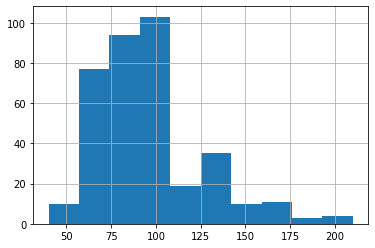

In [59]:
wide_df['WSF2'].hist()

<AxesSubplot:>

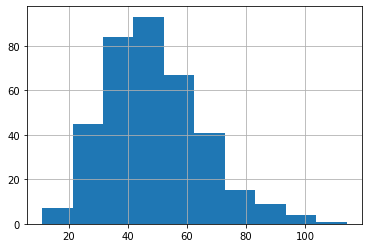

In [60]:
wide_df['AWND'].hist()

In [61]:
tenths_meters_per_sec_to_mph(69)

15.5

In [62]:
wide_df.head(20)

element,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F,bad
0,2020-01-01,69.0,0.0,0.0,41.0,22.0,130.0,188.0,29.2,42.3,15.5,0.0,0.0,39.38,35.96,True
1,2020-01-02,56.0,0.0,0.0,42.0,11.0,94.0,125.0,21.2,28.1,12.6,0.0,0.0,39.56,33.98,False
2,2020-01-03,32.0,0.0,0.0,82.0,67.0,76.0,94.0,17.1,21.2,7.2,0.0,0.0,46.76,44.06,False
3,2020-01-04,24.0,33.0,0.0,81.0,44.0,63.0,81.0,14.2,18.2,5.4,0.1,0.0,46.58,39.92,False
4,2020-01-05,74.0,28.0,0.0,39.0,0.0,139.0,183.0,31.3,41.2,16.6,0.1,0.0,39.02,32.00,True
5,2020-01-06,30.0,0.0,0.0,4.0,-27.0,94.0,134.0,21.2,30.1,6.8,0.0,0.0,32.72,27.14,False
6,2020-01-07,41.0,0.0,0.0,32.0,6.0,98.0,116.0,22.1,26.1,9.2,0.0,0.0,37.76,33.08,False
7,2020-01-08,63.0,5.0,3.0,34.0,-16.0,134.0,179.0,30.1,40.3,14.2,0.0,0.1,38.12,29.12,True
8,2020-01-09,59.0,0.0,0.0,-16.0,-55.0,116.0,161.0,26.1,36.2,13.3,0.0,0.0,29.12,22.10,True
9,2020-01-10,62.0,0.0,0.0,32.0,-16.0,130.0,161.0,29.2,36.2,13.9,0.0,0.0,37.76,29.12,True


### Explore precipitation data

<AxesSubplot:>

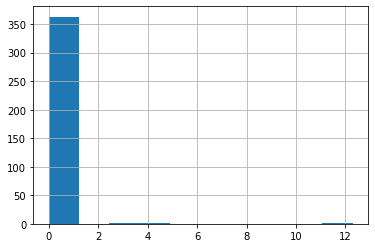

In [63]:
wide_df['SNOW_IN'].hist()

<AxesSubplot:>

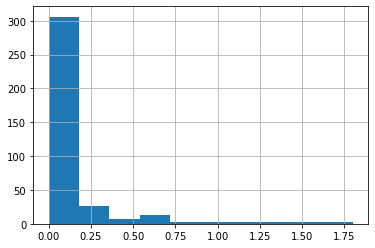

In [64]:
wide_df['PRCP_IN'].hist()

In [65]:
wide_df[wide_df.PRCP_IN > 0.2].head(20)

element,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F,bad
17,2020-01-18,39.0,71.0,76.0,-77.0,-99.0,89.0,107.0,20.0,24.1,8.8,0.3,3.0,18.14,14.18,True
24,2020-01-25,63.0,178.0,0.0,57.0,44.0,125.0,170.0,28.1,38.2,14.2,0.7,0.0,42.26,39.92,True
36,2020-02-06,55.0,112.0,8.0,29.0,11.0,103.0,130.0,23.2,29.2,12.4,0.4,0.3,37.22,33.98,True
37,2020-02-07,67.0,81.0,0.0,42.0,-10.0,183.0,250.0,41.2,56.2,15.1,0.3,0.0,39.56,30.20,True
43,2020-02-13,30.0,135.0,5.0,39.0,17.0,107.0,130.0,24.1,29.2,6.8,0.5,0.2,39.02,35.06,True
48,2020-02-18,48.0,114.0,0.0,30.0,-5.0,89.0,103.0,20.0,23.2,10.8,0.4,0.0,37.40,31.10,True
55,2020-02-25,24.0,66.0,0.0,86.0,61.0,54.0,58.0,12.2,13.0,5.4,0.3,0.0,47.48,42.98,True
57,2020-02-27,101.0,190.0,0.0,72.0,6.0,165.0,241.0,37.1,54.2,22.7,0.7,0.0,44.96,33.08,True
72,2020-03-13,73.0,74.0,0.0,79.0,44.0,148.0,201.0,33.3,45.2,16.4,0.3,0.0,46.22,39.92,True
78,2020-03-19,59.0,142.0,0.0,50.0,39.0,103.0,130.0,23.2,29.2,13.3,0.6,0.0,41.00,39.02,True


In [66]:
wide_df[wide_df.SNOW_IN >= 0.1].head(20)

element,weather_date,AWND,PRCP,SNOW,TAVG,TMIN,WSF2,WSF5,WSF2_MPH,WSF5_MPH,AWND_MPH,PRCP_IN,SNOW_IN,TAVG_F,TMIN_F,bad
7,2020-01-08,63.0,5.0,3.0,34.0,-16.0,134.0,179.0,30.1,40.3,14.2,0.0,0.1,38.12,29.12,True
17,2020-01-18,39.0,71.0,76.0,-77.0,-99.0,89.0,107.0,20.0,24.1,8.8,0.3,3.0,18.14,14.18,True
36,2020-02-06,55.0,112.0,8.0,29.0,11.0,103.0,130.0,23.2,29.2,12.4,0.4,0.3,37.22,33.98,True
43,2020-02-13,30.0,135.0,5.0,39.0,17.0,107.0,130.0,24.1,29.2,6.8,0.5,0.2,39.02,35.06,True
108,2020-04-18,46.0,170.0,18.0,35.0,0.0,94.0,103.0,21.2,23.2,10.3,0.7,0.7,38.30,32.00,True
303,2020-10-30,65.0,66.0,109.0,26.0,-10.0,134.0,174.0,30.1,39.1,14.6,0.3,4.3,36.68,30.20,True
339,2020-12-05,81.0,437.0,8.0,59.0,6.0,157.0,206.0,35.3,46.3,18.2,1.7,0.3,42.62,33.08,True
350,2020-12-16,59.0,10.0,10.0,-53.0,-88.0,139.0,165.0,31.3,37.1,13.3,0.0,0.4,22.46,16.16,True
351,2020-12-17,101.0,330.0,312.0,-32.0,-60.0,174.0,215.0,39.1,48.4,22.7,1.3,12.3,26.24,21.20,True


## Questions
- why 366 rows for each element at one station? Leap Year
- why temperatures so high? **tenths** of degrees
- what is 'S' and 'H' for 'TAVG'?